In [31]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [32]:
!kaggle competitions download -c contradictory-my-dear-watson

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
import os
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px

!pip uninstall -y transformers
!pip install transformers

import transformers
import tokenizers

# Hugging Face new library for datasets (https://huggingface.co/nlp/)
!pip install nlp
import nlp

import datetime

strategy = None

Uninstalling transformers-3.1.0:
  Successfully uninstalled transformers-3.1.0
  Using cached https://files.pythonhosted.org/packages/ae/05/c8c55b600308dc04e95100dc8ad8a244dd800fe75dfafcf1d6348c6f6209/transformers-3.1.0-py3-none-any.whl


In [34]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [35]:
original_train = pd.read_csv("train.csv")

original_train = sklearn.utils.shuffle(original_train)
original_train = sklearn.utils.shuffle(original_train)

validation_ratio = 0.2
nb_valid_examples = max(1, int(len(original_train) * validation_ratio))

original_valid = original_train[:nb_valid_examples]
original_train = original_train[nb_valid_examples:]
print(f"original - training: {len(original_train)} examples")
original_train.head(10)

original - training: 9696 examples


,id,premise,hypothesis,lang_abv,language,label
11899,9e387ddc0e,"As it is now, Web companies not only have the ...",Web companies use this advantage to assist tho...,en,English,1
11773,06e4c7465f,The only comprehensible explanation is that th...,The only explanation is that nothing has taken...,en,English,2
10029,13b25863e3,Если вы найдете имена Peculiar (Миссури) или т...,"Сурпрайз — населенный пункт в штате Небраска, ...",ru,Russian,0
3427,00b23f5bb3,и еще это заставит людей компактнее складывать...,"Люди, ограничивающие количество мусора, являют...",ru,Russian,0
11515,981ce3a391,"4 million homes watch the evening news on CBS,...","CBS, ABC and NBC are the leaders in news.",en,English,1
5717,8412e2ea58,انسانی دیکھ بھال کے ساتھ ساتھ جنگل میں بھی ہات...,یہ ہر جگہ ہاتھوں کی مدد کرے گا.,ur,Urdu,0
1145,446e09261b,well um i uh exercise regularly i work at a un...,I am a fit person with 1.4% body fat.,en,English,1
5400,2f64d4f23a,the hologram makes up all these things and uh ...,We have nothing to do but stare at the walls t...,en,English,2
5030,ec65bff4f8,"A proserous tourist district, it is full of sh...",The rich tourist district has shopping centers...,en,English,0
7933,a1839531f3,Hamon said the proposed bill has attracted a n...,The proposed bill would make Legal Aid accessi...,en,English,1


In [36]:
original_test = pd.read_csv("test.csv")
print(f"original - test: {len(original_test)} examples")
original_test.head(10)

original - test: 5195 examples


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English
7,a16f7ed56b,C'était probablement la première chose dont je...,C'était l'un de mes premiers souvenirs.,fr,French
8,6d9fa191e6,"agencies' operating trust, enterprise and inte...",Agencies in financial trouble are usually audi...,en,English
9,c156e8fed5,Hakuna aliyejua walipokwenda.,Mafiko yao ilikuwa ni siri,sw,Swahili


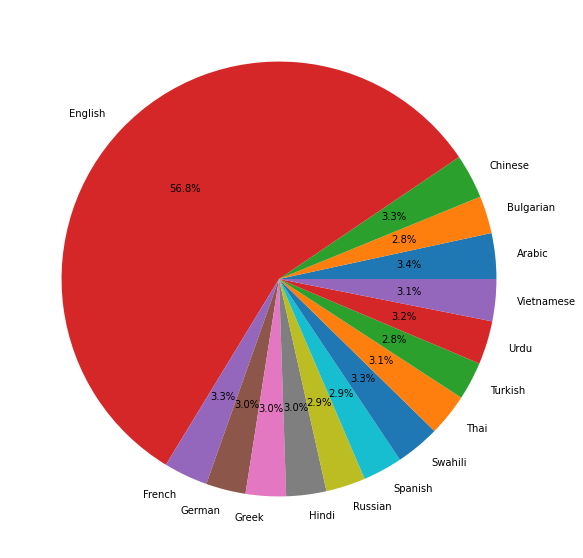

In [37]:
labels, frequencies = np.unique(original_train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [38]:
from transformers import BertTokenizer, TFBertModel
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Check TPU devices

In [39]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.17.207.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.17.207.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [40]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)
encode_sentence("My name is watson.")

[11590, 11324, 10124, 11803, 11599, 119, 102]

In [48]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]# classification task
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

train_input = bert_encode(original_train.premise.values, original_train.hypothesis.values, tokenizer)

In [49]:
train_input['input_word_ids']

<tf.Tensor: shape=(9696, 259), dtype=int32, numpy=
array([[  101, 10882, 10271, ...,     0,     0,     0],
       [  101, 10117, 10893, ...,     0,     0,     0],
       [  101, 33463, 96195, ...,     0,     0,     0],
       ...,
       [  101, 10117, 10404, ...,     0,     0,     0],
       [  101,   225, 26835, ...,     0,     0,     0],
       [  101, 20321, 28462, ...,     0,     0,     0]], dtype=int32)>

In [43]:
max_len = 50

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  #define optimization way, loss function, and metrics.
    
    return model

In [44]:
max_len = 50

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [45]:
with strategy.scope():#各TPUごとに処理
    model = build_model()
    model.summary()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [52]:
model.fit(train_input, original_train.label.values, epochs = 200, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/200
  2/122 [..............................] - ETA: 23s - loss: 0.7144 - accuracy: 0.7109WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_train_batch_end` time: 0.1895s). Check your callbacks.


122/122 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7323WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_test_batch_end` time: 0.0519s). Check your callbacks.


122/122 [==============================] - 27s 217ms/step - loss: 0.6376 - accuracy: 0.7323 - val_loss: 0.8531 - val_accuracy: 0.6366
Epoch 2/200
122/122 [==============================] - 27s 218ms/step - loss: 0.4922 - accuracy: 0.8065 - val_loss: 0.9812 - val_accuracy: 0.6180
Epoch 3/200
122/122 [==============================] - 27s 218ms/step - loss: 0.3473 - accuracy: 0.8660 - val_loss: 1.2201 - val_accuracy: 0.6247
Epoch 4/200
122/122 [==============================] - 27s 220ms/step - loss: 0.2398 - accuracy: 0.9136 - val_loss: 1.3619 - val_accuracy: 0.6289
Epoch 5/200
122/122 [==============================] - 27s 219ms/step - loss: 0.1508 - accuracy: 0.9475 - val_loss: 1.5887 - val_accuracy: 0.6330
Epoch 6/200
122/122 [==============================] - 27s 219ms/step - loss: 0.0956 - accuracy: 0.9692 - val_loss: 1.7566 - val_accuracy: 0.6175
Epoch 7/200
122/122 [==============================] - 27s 218ms/step - loss: 0.0783 - accuracy: 0.9723 - val_loss: 2.0034 - val_accurac

KeyboardInterrupt: ignored

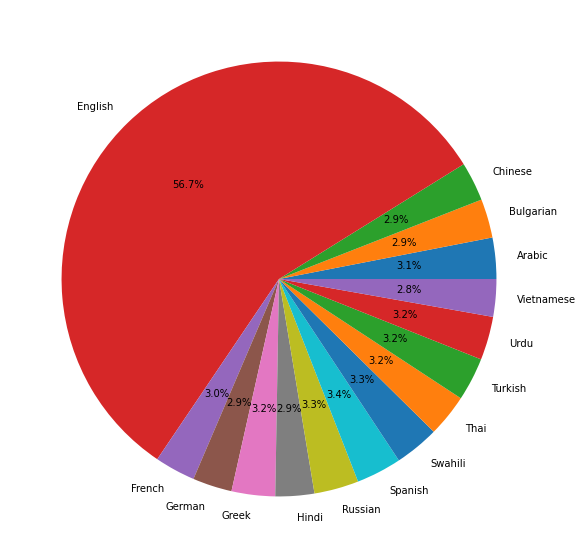

In [54]:
test = pd.read_csv("test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)
labels, frequencies = np.unique(test.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [55]:
test.head()
predictions = [np.argmax(i) for i in model.predict(test_input)]
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.head()


,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2
